## Import Libaries

In [ ]:
!pip install -U transformers
!pip install wandb
!pip install flask-ngrok
!pip install jinja2==3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import spacy
import nltk, string
import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns
import warnings, torch
import tensorflow as tf
from gensim.models import Word2Vec
warnings.filterwarnings('ignore')
nlp = spacy.load('en_core_web_sm')
from transformers import Trainer, TrainingArguments
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## Wand login for loggin loss

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Load the dataset

In [ ]:
# load the preprocessed dfset
df = pd.read_csv('preprocessed_emotion_dataset.csv')
df.drop(['tweet'], axis=1,inplace=True)
display(df.head())

,clean_tweet,emotion
0,time ticking fast relive past happy joy face,happy
1,happy birthday one hot love much amazing frien...,happy
2,best cheer left min cant save happy like treas...,happy
3,good morning wishing day filled sunshine happi...,happy
4,eric movie made happy several way think rely s...,happy


## Convert categories of label into numbers

In [ ]:
label_encoder = preprocessing.LabelEncoder()
df['label'] = pd.DataFrame(label_encoder.fit_transform(df.emotion))
print(df.label.unique())
df.head()

[3 4 0 2 1 5]


,clean_tweet,emotion,label
0,time ticking fast relive past happy joy face,happy,3
1,happy birthday one hot love much amazing frien...,happy,3
2,best cheer left min cant save happy like treas...,happy,3
3,good morning wishing day filled sunshine happi...,happy,3
4,eric movie made happy several way think rely s...,happy,3


In [ ]:
# create label to numeric map
label_map = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "sad", 5: "surprise"}

## Plot Histrogram of length of tweet

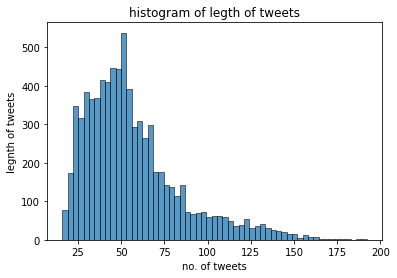

In [ ]:
# plot histogram of tweet legnth
length_list = []
for sent in df.clean_tweet:
  length_list.append(len(sent))

sns.histplot(length_list)
plt.title("histogram of legth of tweets")
plt.xlabel("no. of tweets")
plt.ylabel("legnth of tweets")
plt.show()

## Extract POS tags for each tweet and concat with original tweet text


In [ ]:
# find pos tags of each sentences
pos_tag_list = []
for sent in df.clean_tweet:
  doc = nlp(sent)
  temp = []
  for token in doc:
    temp.append(token.pos_)
  pos_tag_list.append(sent + " " + " ".join(temp))


df_pos = pd.DataFrame(pos_tag_list, columns=['tweet_with_pos'])
df_pos.head()

,tweet_with_pos
0,time ticking fast relive past happy joy face N...
1,happy birthday one hot love much amazing frien...
2,best cheer left min cant save happy like treas...
3,good morning wishing day filled sunshine happi...
4,eric movie made happy several way think rely s...


In [ ]:
df_pos.tweet_with_pos[0]

'time ticking fast relive past happy joy face NOUN VERB ADV NOUN ADP ADJ NOUN VERB'

In [ ]:
# select feature asn labels
x = df_pos.tweet_with_pos.tolist()
y = list(df.label)

## Split the dataset

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

## Created Pytorch Dataset for Bert model

In [ ]:
import torch


# function to evaluate test set
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Bert model Training, Prediction and Saving**

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
device = torch.device("cuda")
print(device)


# initialize model
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model1 = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=6)


# get bert tokens embeddings from tweet 
x_train_tokenized = tokenizer(x_train, padding=True, truncation=True, max_length=150)
x_test_tokenized = tokenizer(x_test, padding=True, truncation=True, max_length=150)


# convert token embedding to Pytorch Dataset
train_dataset = Dataset(x_train_tokenized, y_train)
test_dataset = Dataset(x_test_tokenized, y_test)


# set training arguments
args = TrainingArguments(output_dir="./output",
                         num_train_epochs=9,
                         warmup_steps=500,
                         evaluation_strategy="steps",
                         per_device_train_batch_size=8,
                         per_device_eval_batch_size=8,
                         weight_decay=0.01,
                         logging_dir='./logs',
                         logging_steps=500,
                         eval_steps=500,
                         report_to='wandb',
                         run_name='bert-base-cased')



# intialize Trainer 
trainer = Trainer(model=model1,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset,
                  compute_metrics=compute_metrics)



# train and test model
trainer.train()
wandb.finish()



# save model
trainer.save_model("./model/bert_base_cased")
print("model saved")

cuda


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,1.097600,0.543467,0.843264,0.850604,0.843264,0.843588
1000,0.485900,0.492013,0.882772,0.886004,0.882772,0.880869
1500,0.408600,0.460160,0.875648,0.890545,0.875648,0.878779
2000,0.295700,0.510840,0.894430,0.897744,0.894430,0.892850
2500,0.247300,0.505899,0.895725,0.896529,0.895725,0.895789
3000,0.183900,0.569169,0.900907,0.901474,0.900907,0.900788
3500,0.112100,0.644784,0.902202,0.902326,0.902202,0.902218
4000,0.099400,0.623731,0.903497,0.903038,0.903497,0.903020
4500,0.061800,0.698229,0.902202,0.902051,0.902202,0.901935
5000,0.048400,0.685430,0.902202,0.901711,0.902202,0.901791


<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>


eval/accuracy,▁▅▅▇▇▇███████
eval/f1,▁▅▅▇▇████████
eval/loss,▃▂▁▂▂▃▅▄▆▆▇▇█
eval/precision,▁▆▆▇▇████████
eval/recall,▁▅▅▇▇▇███████
eval/runtime,█▄▄▂▂▃▂▄▂▃▁▃▂
eval/samples_per_second,▁▅▅▇▇▆▇▅▇▆█▆▇
eval/steps_per_second,▁▅▅▇▇▆▇▅▇▆█▆▇
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇███
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇███
train/learning_rate,█▇▇▆▆▅▅▄▃▃▂▂▁


model saved


## **Load saved model and Predict the Emotion for New Tweet**

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
device = torch.device("cuda")
print(device)


# initialize model
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
saved_model1 = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/model/bert_base_cased', num_labels=6)
print("saved model loaded")

cuda
saved model loaded


In [ ]:
text = input("Enter the tweet text : ")
encoding1 = tokenizer(text, return_tensors="pt")
encoding1 = {k: v.to(trainer.model.device) for k,v in encoding1.items()}


outputs = trainer.model(**encoding1)
label = torch.argmax(outputs['logits']).item()
print(label_map[label])